In [1]:
# eeg analysis libraries
import mne
import ssvepy

# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *

# numerical libraries
import numpy as np
import pandas as pd

# import tqdm for a progress bar:
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# import file path operators
from pathlib import Path
import os

# avoid MNE being too verbose
mne.set_log_level('ERROR')

## List all the files

List all files that match the filenaming system & create lists of group variables and IDs

In [2]:
# datafolder = Path('/Users/jan/Documents/eeg-data/big-protocol/')
datafolder = Path('/Volumes/Seagate Expansion Drive/cambridge')

datafiles = list(datafolder.glob(pattern='*SocSSVEP*.bdf'))

group = [f.name[3:6] for f in datafiles]

pids = [f.name[7:12] for f in datafiles]


## Loop over files and do the SSVEP analysis

In [ ]:

datadicts = []
ssveps = []

for file in tqdm(datafiles):

    # create an MNE raw structure
    raw = mne.io.read_raw_edf(file, montage=mne.channels.read_montage('biosemi64'),
                              eog=[f'EXG{n}' for n in range(1, 9)])
    
    raw.info['subject_info'] = {'pid': file.name[7:11], 'group': file.name[3:6]}

    # find the trigger codes
    events = mne.find_events(raw)
    
    # if there is only one event code, the triggers were messed up :(
    # unfortunately this is true for a quite a few of the early files
    if np.unique(events[:, 2]).size == 1:
        continue
        
    # segment the data
    epochs = [mne.Epochs(
        raw, events[events[:, 2] % 2 == a, :], tmin=0, tmax=4
    ).set_eeg_reference().load_data().apply_proj()
              for a in [1, 0]]
        
    # set a common reference
    # epochs.set_eeg_reference()
    # epochs.load_data()
    # epochs.apply_proj()
    
    # do the ssvep analysis
    ssvep = [ssvepy.Ssvep(epoch, [18], noisebandwidth=4.0,
                          compute_harmonics=False,
                          compute_subharmonics=False,
                          compute_intermodulation=False)
             for epoch in epochs]
    
#     ssvep.topoplot_snr()
    
    ssveps.append(ssvep)
    
    # which channels to use
    occipital_elecs = mne.pick_channels(raw.ch_names, ['Oz', 'O1', 'O2', 'Iz'])

    datadicts.append(
        {'pid': raw.info['subject_info']['pid'],
         'group': raw.info['subject_info']['group'],
         'occipital_snr_social': ssvep[1].stimulation.snr[:, occipital_elecs].mean(),
         'occipital_snr_nonsocial': ssvep[0].stimulation.snr[:, occipital_elecs].mean()}
    )
    
# save everything to a CSV file
pd.DataFrame(datadicts).to_csv('occipital_snrs.csv');

# Comparison of one individual to the rest of the group

In [23]:
from plotnine import *

data = pd.read_csv('occipital_snrs.csv')
data = data.set_index('pid')

individual = '0055'


### Response to Social images

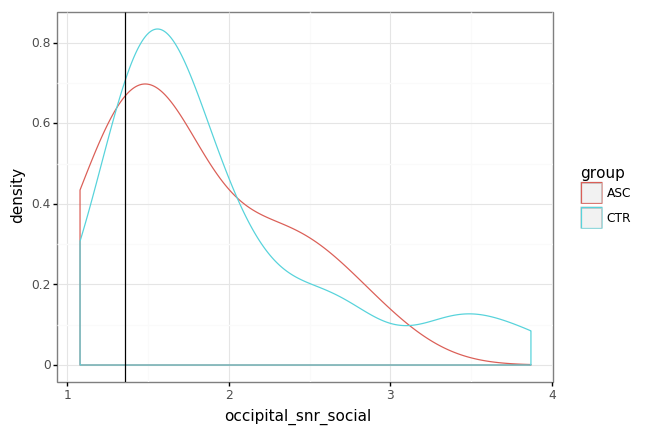

<ggplot: (300887679)>

In [68]:
(ggplot(data, aes(x='occipital_snr_social', color='group')) +
 geom_density() +
 geom_vline(xintercept=data['occipital_snr_social'][int(individual)]) +
 theme_bw()
)

### Response to Non-social images

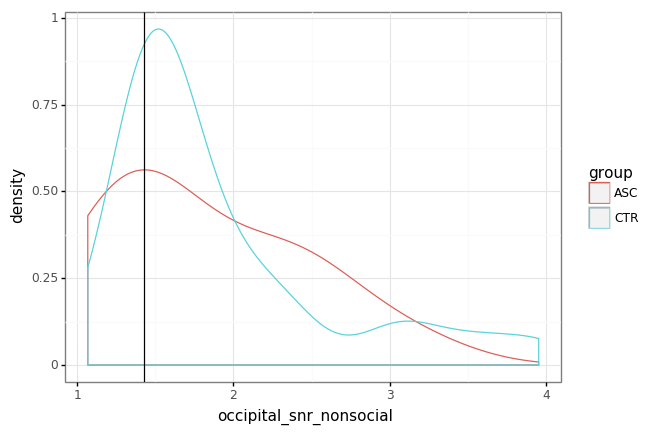

<ggplot: (307232253)>

In [67]:
(ggplot(data, aes(x='occipital_snr_nonsocial', color='group')) +
 geom_density() +
 geom_vline(xintercept=data['occipital_snr_nonsocial'][int(individual)]) +
 theme_bw()
)

# Comparison of the spatial spread compared to the group

### Social

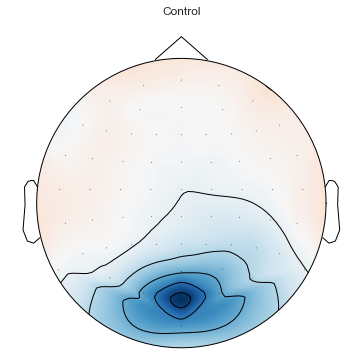

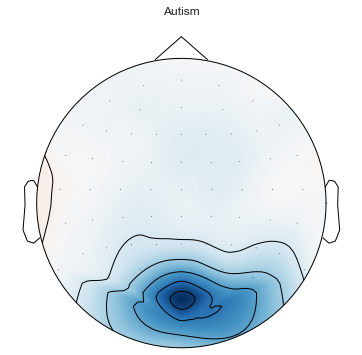

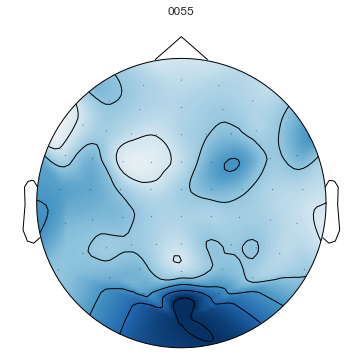

In [65]:
control_snr = [np.mean(
    np.stack([ssvep[idx].stimulation.snr.mean(axis=0) for ssvep in ssveps
              if ssvep[idx].info['subject_info']['group'] == 'CTR'],
             axis=-1),
    axis=-1
)
               for idx in [0, 1]]

autism_snr = [np.mean(
    np.stack([ssvep[idx].stimulation.snr.mean(axis=0) for ssvep in ssveps
              if ssvep[idx].info['subject_info']['group'] == 'ASC'],
             axis=-1),
    axis=-1
)
            for idx in [0, 1]]

individual_snr = [np.mean(
    np.stack([ssvep[idx].stimulation.snr.mean(axis=0) for ssvep in ssveps
              if ssvep[idx].info['subject_info']['pid'] == individual],
             axis=-1),
    axis=-1
)
            for idx in [0, 1]]


pos = mne.channels.layout._auto_topomap_coords(
            raw.info, mne.pick_types(raw.info, meg=True, eeg=True)
        )


mne.viz.plot_topomap(control_snr[1], pos, cmap='RdBu', show=False)
plt.title('Control')
plt.show()

mne.viz.plot_topomap(autism_snr[1], pos, cmap='RdBu', show=False)
plt.title('Autism')
plt.show()

mne.viz.plot_topomap(individual_snr[1], pos, cmap='RdBu', show=False)
plt.title(individual)
plt.show()


### Nonsocial

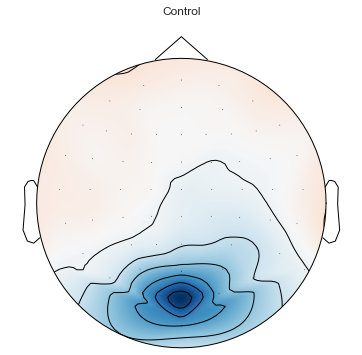

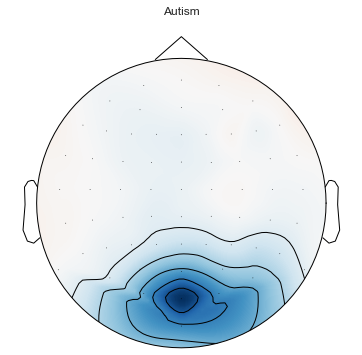

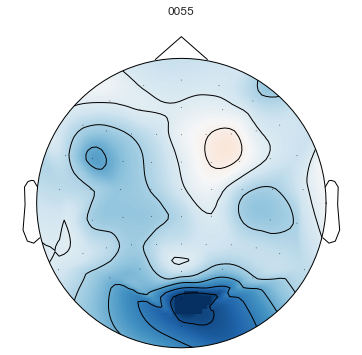

In [66]:
mne.viz.plot_topomap(control_snr[0], pos, cmap='RdBu', show=False)
plt.title('Control')
plt.show()

mne.viz.plot_topomap(autism_snr[0], pos, cmap='RdBu', show=False)
plt.title('Autism')
plt.show()

mne.viz.plot_topomap(individual_snr[0], pos, cmap='RdBu', show=False)
plt.title(individual)
plt.show()

